In [1]:
import data, roc
import torch, os, random, PIL, time
import numpy as np
import torch.nn as nn
import torchvision.transforms as transforms
from utils import seed_everything, CFG

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
data_root = "D:\\Datasets\\SJS\\"
processed_root = os.path.join(data_root, "Processed")
plot_root = "E:\\Results\\SJS\\Figures\\"
os.makedirs(plot_root, exist_ok=True)

excel_root = "C:\\Users\\PC00\\Desktop\\SJS\\"
os.makedirs(excel_root, exist_ok=True)

In [3]:
model_save_root = "E:\\model_save_path\\SJS\\NEW\\"
PG_save_path = os.path.join(model_save_root, "PG_Res.pt")
SG_save_path = os.path.join(model_save_root, "SG_Res.pt")

In [4]:
seed_everything(CFG["SEED"])

SJS_path = data.path_by_diagnosis(processed_root, "SJS")
CTR_path = data.path_by_diagnosis(processed_root, "NORMAL")
SJS_ID = data.ID_summary(SJS_path)
CTR_ID = data.ID_summary(CTR_path)
print(len(SJS_ID), len(CTR_ID))

train_SJS_idx = random.sample(range(len(SJS_ID)), int(len(SJS_ID)*CFG["TEST_PORTION"]))
train_CTR_idx = random.sample(range(len(CTR_ID)), int(len(CTR_ID)*CFG["TEST_PORTION"]))

train_SJS_ID = [SJS_ID[i] for i in train_SJS_idx]
train_CTR_ID = [CTR_ID[i] for i in train_CTR_idx]
test_SJS_ID = [x for x in SJS_ID if x not in train_SJS_ID]
test_CTR_ID = [x for x in CTR_ID if x not in train_CTR_ID]

train_SJS_path = data.path_by_IDs(train_SJS_ID, SJS_path)
train_CTR_path = data.path_by_IDs(train_CTR_ID, CTR_path)
test_SJS_path = data.path_by_IDs(test_SJS_ID, SJS_path)
test_CTR_path = data.path_by_IDs(test_CTR_ID, CTR_path)

train_IDs = train_SJS_ID + train_CTR_ID
test_IDs = test_SJS_ID + test_CTR_ID
train_paths = train_SJS_path + train_CTR_path
test_paths = test_SJS_path + test_CTR_path
print(len(train_paths), len(test_paths))

resize = transforms.Compose([
    transforms.Resize((CFG["IMG_SIZE"], CFG["IMG_SIZE"])),
    transforms.ToTensor()
])

227 399
312 314


In [5]:
class conv7_filter(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(conv7_filter, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, 7, 2, 3)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

class conv3_filter(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(conv3_filter, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, 3, 1, 1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.conv1 = nn.Sequential(conv7_filter(3, 64), nn.MaxPool2d(3, 2, 1))
        self.conv2 = nn.Sequential(conv3_filter(64, 64), conv3_filter(64, 128), nn.MaxPool2d(3, 2, 1))
        self.conv3 = nn.Sequential(conv3_filter(128, 128), conv3_filter(128, 256), nn.MaxPool2d(3, 2, 1))
        self.conv4 = nn.Sequential(conv3_filter(256, 256), conv3_filter(256, 512), nn.MaxPool2d(3, 2, 1))
        self.conv5 = nn.Sequential(conv3_filter(512, 512), conv3_filter(512, 512))
        self.avg_pool = nn.AvgPool2d(7, 1, 0)
        self.classifier = nn.Linear(512, 2)
        self.softmax = nn.Softmax(dim=-1)

        self.apply(self._init_weights)
    
    def _init_weights(self, m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x4 = self.conv4(x3)
        x5 = self.conv5(x4)
        pool = self.avg_pool(x5)
        out = self.classifier(pool.flatten())
        out = self.softmax(out)
        return out

In [6]:
PG_model = ResNet()
SG_model = ResNet()
PG_model = nn.DataParallel(PG_model)
SG_model = nn.DataParallel(SG_model)
PG_model.to(device)
SG_model.to(device)
PG_loss_fn = nn.CrossEntropyLoss().to(device)
SG_loss_fn = nn.CrossEntropyLoss().to(device)
PG_optimizer = torch.optim.Adam(PG_model.parameters(), lr=CFG["LR"])
SG_optimizer = torch.optim.Adam(SG_model.parameters(), lr=CFG["LR"])
PG_scheduler = torch.optim.lr_scheduler.ExponentialLR(PG_optimizer, gamma=0.95)
SG_scheduler = torch.optim.lr_scheduler.ExponentialLR(SG_optimizer, gamma=0.95)

In [7]:
torch.autograd.set_detect_anomaly(True)
PG_model.train()
SG_model.train()
for epoch in range(50):
    start_time = time.time()
    for idx, ID in enumerate(train_IDs):
        curr_datalist = train_paths[idx]
        curr_label = torch.Tensor([1,0] if ID in CTR_ID else [0,1]).to(device)
        for datapath in curr_datalist:
            curr_data = resize(PIL.Image.open(datapath)).to(torch.float32).unsqueeze(0).to(device)
            data_gland = datapath.split("\\")[-1].split("_")[0]
            if data_gland == "PTG":
                PG_out = PG_model(curr_data)
                PG_loss = PG_loss_fn(PG_out, curr_label)
                PG_optimizer.zero_grad()
                PG_loss.backward()
                PG_optimizer.step()
            else:
                SG_out = SG_model(curr_data)
                SG_loss = SG_loss_fn(SG_out, curr_label)
                SG_optimizer.zero_grad()
                SG_loss.backward()
                SG_optimizer.step()
    end_time = time.time()
    time_spent = end_time - start_time
    if (epoch%5) == 0:
        PG_scheduler.step()
        SG_scheduler.step()
        print(f"[Epoch{epoch+1}] Loss: {PG_loss.item()}(PG)\t{SG_loss.item()}(SG)\tSpent {time_spent//60}min {time_spent%60}sec")
torch.save(PG_model.state_dict(), PG_save_path)
torch.save(SG_model.state_dict(), SG_save_path)

[Epoch1] Loss: 0.313972532749176(PG)	0.31433266401290894(SG)	Spent 4.0min 4.926024913787842sec
[Epoch6] Loss: 0.31382229924201965(PG)	0.31455010175704956(SG)	Spent 3.0min 48.46964144706726sec
[Epoch11] Loss: 0.3141242265701294(PG)	0.3143538236618042(SG)	Spent 3.0min 49.374847173690796sec
[Epoch16] Loss: 0.31368720531463623(PG)	0.3143622577190399(SG)	Spent 3.0min 44.33771300315857sec
[Epoch21] Loss: 0.3135240972042084(PG)	0.3141172528266907(SG)	Spent 3.0min 42.13973903656006sec
[Epoch26] Loss: 0.31440481543540955(PG)	0.3148094415664673(SG)	Spent 3.0min 42.40649056434631sec
[Epoch31] Loss: 0.3137899935245514(PG)	0.31520015001296997(SG)	Spent 3.0min 42.39441752433777sec
[Epoch36] Loss: 0.3141520917415619(PG)	0.3149372637271881(SG)	Spent 3.0min 43.33482527732849sec
[Epoch41] Loss: 0.3141341507434845(PG)	0.31465575098991394(SG)	Spent 3.0min 46.850385665893555sec
[Epoch46] Loss: 0.3142753839492798(PG)	0.3189018666744232(SG)	Spent 3.0min 46.911794900894165sec


In [11]:
PG_model.load_state_dict(torch.load(PG_save_path, map_location="cuda"))
SG_model.load_state_dict(torch.load(SG_save_path, map_location="cuda"))
PG_model.eval()
SG_model.eval()
total_preds, total_labels = [], []
for idx, ID in enumerate(test_IDs):
    curr_datalist = test_paths[idx]
    curr_label = torch.Tensor([1,0] if ID in CTR_ID else [0,1])
    for datapath in curr_datalist:
        curr_data = resize(PIL.Image.open(datapath)).to(torch.float32).unsqueeze(0).to(device)
        data_gland = datapath.split("\\")[-1].split("_")[0]
        if data_gland == "PTG":
            PG_out = PG_model(curr_data)
            pred = PG_out.detach().cpu().tolist()
        else:
            SG_out = SG_model(curr_data)
            pred = SG_out.detach().cpu().tolist()
        total_preds.append(pred)
        total_labels.append(curr_label)

In [15]:
import matplotlib.pyplot as plt
import math

def true_positive_rate(preds, labels, threshold):
    total_positive = sum(labels)
    th_preds = [1 if x > threshold else 0 for x in preds]
    tp_count = sum(a==1 and b==1 for a, b in zip(labels, th_preds))
    return tp_count / total_positive

def false_positive_rate(preds, labels, threshold):
    total_negative = len(labels) - sum(labels)
    th_preds = [1 if x > threshold else 0 for x in preds]
    fp_count = sum(a==0 and b==1 for a, b in zip(labels, th_preds))
    return fp_count / total_negative

def accuracy(preds, labels, threshold):
    total = len(labels)
    th_preds = [1 if x > threshold else 0 for x in preds]
    correct = sum(a==b for a, b in zip(labels, th_preds))
    return correct / total

def auc_score(tprs, fprs):
    area = 0
    for i in range(len(tprs)-1):
        area += 0.5 * (tprs[i] + tprs[i+1]) * (fprs[i] - fprs[i+1])
    return area

def roc_curve(preds, labels, category):
    tpr, fpr = [], []
    best_acc = 0

    preds, labels = np.array(preds), np.array(labels)
    if category == "CTR":
        preds, labels = preds[:,0], labels[:,0]
    else:
        preds, labels = preds[:,1], labels[:,1]
    
    low, high = math.floor(min(preds)), math.ceil(max(preds))
    thresholds = np.linspace(low, high, 100)
    for thresh in thresholds:
        tpr.append(true_positive_rate(preds, labels, thresh))
        fpr.append(false_positive_rate(preds, labels, thresh))
        acc = accuracy(preds, labels, thresh)
        if acc > best_acc: best_acc = acc
    
    score = auc_score(tpr, fpr)

    plt.figure(figsize = (18, 12))
    plt.plot(fpr, tpr)
    plt.plot([0,1],[0,1], "gray", linestyle="dotted")
    plt.xlabel('False-Positive Rate')
    plt.ylabel('True-Positive Rate')
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.title('Area Under ROC Curve')
    plt.legend((f"AUC = {100*score:.2f}\nACC = {100*best_acc:.2f}", " "), loc="lower right")
    plt.show()
    return

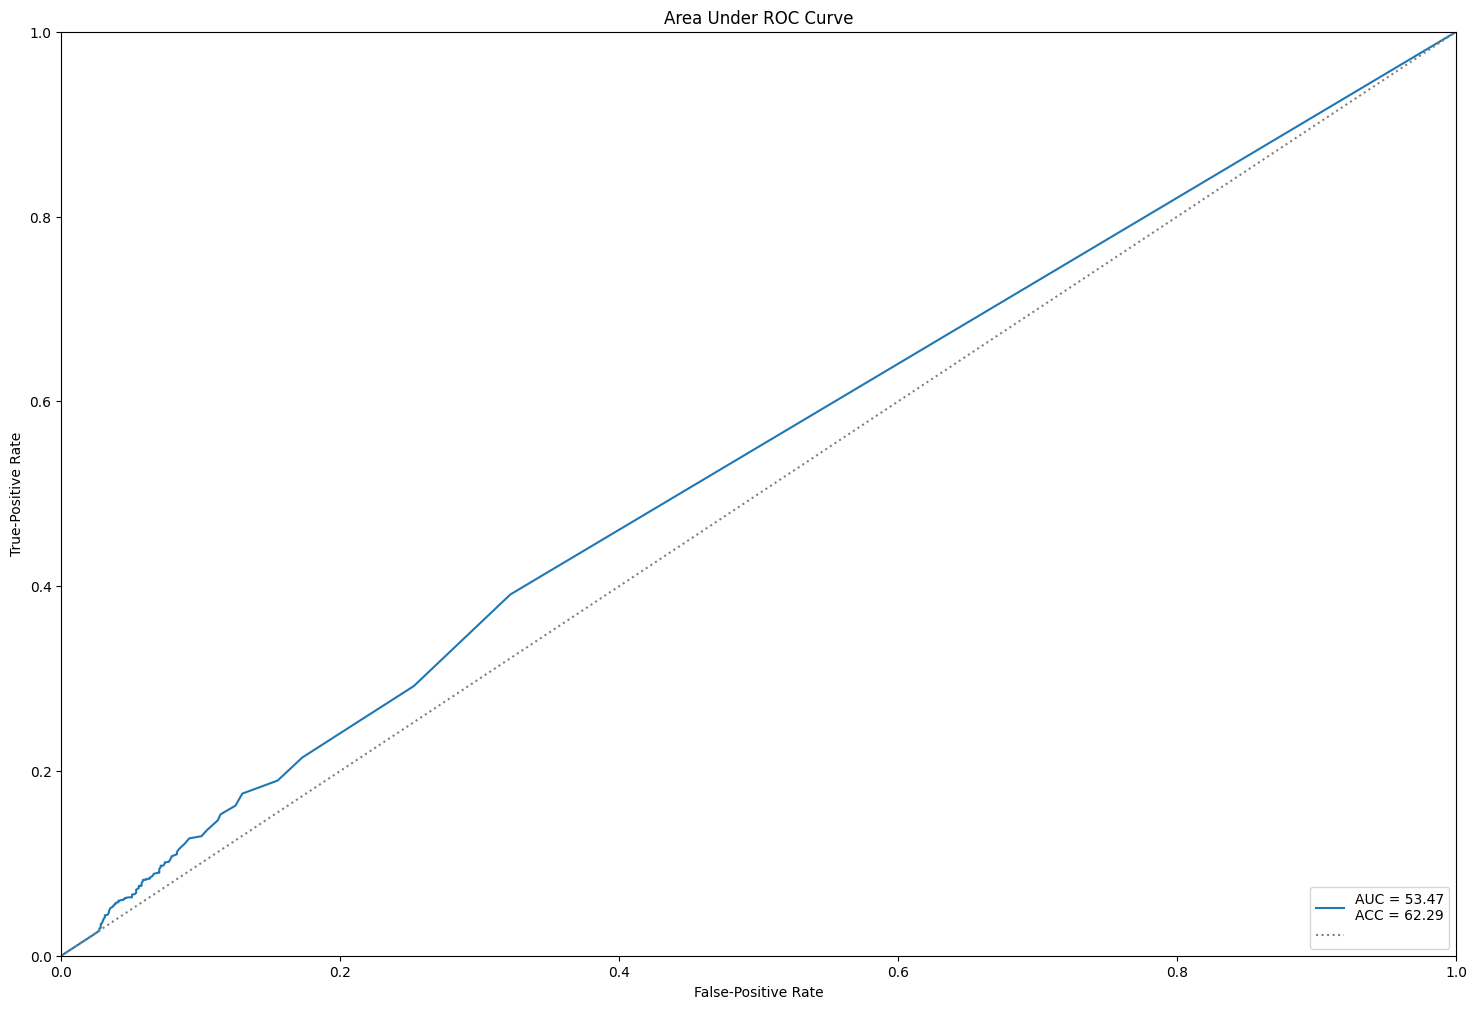

In [16]:
roc_curve(total_preds, total_labels, "SJS")